In [214]:
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 

import warnings
warnings.filterwarnings('ignore')

In [151]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv')

- 첫타자와 둘째타자의 각 이닝별 출루현황, 해당 이닝의 득점수를 3columns의 데이터로 변환
- 정수형 값이 아닌 데이터 행를 제거
- 홈런 (4)값을 가지는 행을 제거
- 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
- 둘째 타자 출루 결과를 one-hot encoding

In [163]:
lst = []
for i in range(1,10): 

    x = df[['game_id', f'a{i}_1' , f'a{i}_2' , f'b{i}']].copy()
    x.columns = ['game_id' ,'a1', 'a2' ,'score']
    x.loc[:,'inning'] = i 
    lst.append(x) 

t = pd.concat(lst, axis = 0).reset_index(drop = True)


In [168]:
# 숫자로 변환 가능한 문자열만 남김 
t2 = t[t.a1.map(lambda x : str(x).isdigit())].reset_index(drop=True)

t2['a1'] = t2['a1'].astype('int')
t2['a2'] = t2['a2'].astype('int')
t3 = t2[(t2.a1 != 4) & (t2.a2 != 4)].reset_index(drop = True)
t3.a2.unique()


array([5, 6, 7, 1, 2, 3, 9, 8])

In [199]:
## 둘째 타자 출루 결과 one-hot-coing 
one_hot = pd.get_dummies(t3.a2.astype('str')).astype('int')
one_hot.columns = ['Second' + str(x) for x in one_hot.columns]
final_df = pd.concat([t3[['game_id','a1', 'score','inning']], one_hot], axis = 1).reset_index(drop = True)

In [200]:
final_df

,game_id,a1,score,inning,Second1,Second2,Second3,Second5,Second6,Second7,Second8,Second9
0,201900016,5,0,1,0,0,0,1,0,0,0,0
1,201900103,5,0,1,0,0,0,0,1,0,0,0
2,201900112,5,0,1,0,0,0,0,0,1,0,0
3,201900131,5,0,1,1,0,0,0,0,0,0,0
4,201900141,6,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1602,201902307,1,7,9,0,0,0,0,0,0,0,1
1603,201902327,7,0,9,0,0,0,1,0,0,0,0
1604,201902346,6,1,9,1,0,0,0,0,0,0,0
1605,201902365,1,2,9,0,0,0,0,0,0,0,1


## 4-1 데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정

In [269]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

X = final_df.drop(['game_id', 'Second9'], axis = 1)
y = final_df.Second9

c_x = sm.add_constant(X)

model = sm.Logit(y, c_x)
result = model.fit()

# 예측 확률값 
y_pred = result.predict(c_x)
y_pred = np.where(y_pred >= 0.5 , 1, 0)
# 정확도
accuracy = accuracy_score(y, y_pred)

print(result.summary())
print(f"회귀계수 : {result.params}")
print(f"정확도 {accuracy:.4f}")

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                Second9   No. Observations:                 1607
Model:                          Logit   Df Residuals:                     1596
Method:                           MLE   Df Model:                           10
Date:                Sat, 05 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        18:22:55   Log-Likelihood:            -5.4846e-06
converged:                      False   LL-Null:                       -338.31
Covariance Type:            nonrobust   LLR p-value:                6.533e-139
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.5851   1314.093      0.013      0.989   -2557.990    2593.160
a1             0.0472    246.671      0.000      1.000    -483.41

4-3 SMOTE (random_state =0 지정)를 적용하여 data imbalance를 해결하라

In [284]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(sampling_strategy = 'auto', random_state= 0)
s_x, s_y = smote.fit_resample(X, y)
print(s_x.shape)
s_y.value_counts()

(3040, 10)


Second9
0    1520
1    1520
Name: count, dtype: int64

구성 데이터에 Logistic Regression을 적용하고 결과를 분석하라

In [289]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error , r2_score , accuracy_score

x_train, x_test , y_train, y_test = train_test_split(s_x, s_y, test_size = 0.3, random_state = 123, stratify= s_y)

lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test) 

score = accuracy_score(lr_pred, y_test)
print(f"{score:.4f}") 


0.9967


#### 구성 데이터에 XGB 적용하고 결과를 분석

0.9978


<BarContainer object of 10 artists>

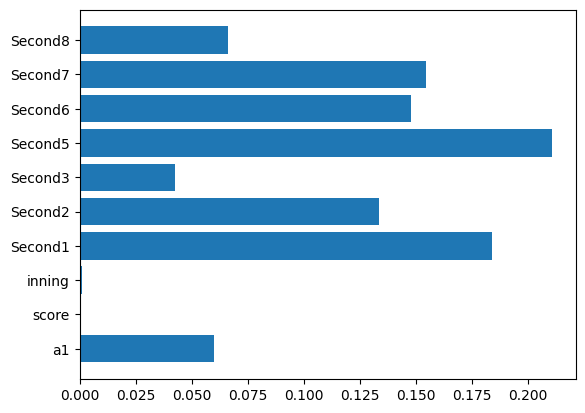

In [296]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)
accu = accuracy_score(y_test, xgb_pred)
print(f"{accu:.4f}")

plt.barh(xgb.feature_names_in_ , xgb.feature_importances_)

제품 A의 불량률은 0.03이다. 25개의 제품을 뽑았을 때 3개가 불량일 확률을

In [344]:
from scipy.stats import binom , norm, stats

p = 0.03
n = 25

rv = binom(n, p)
rv.pmf(3)

np.float64(0.03177384363983214)

C사 생산 제품 1000개 중 양품이 600개, D사 생산 제품 500개 중 양품이 200개 이다. </br>
두 회사의 양품률에 차이가 있는지 검정하여라

In [339]:
n1 = 1000 
p1 = 600 / 1000 

n2 = 500
p2 = 200 / 500 
confa = 0.05
# SE 
se = np.sqrt((p1 * (1 - p1) /n1 ) + (p2 * (1 - p2) /n2 ))

# diff
d = p1 - p2 
# z_stat
z_stat = (p1 - p2) / se

# p_value 
p_value = 2 * (1 - norm.cdf(np.abs(z_stat)))
print(z_stat)
p_value

7.453559924999298


np.float64(9.08162434143378e-14)

아래 데이터는 a,b,c,d 네 차종 각각 5회 실험 시 범퍼 파손 정도 이다. (단, 각 모집단은 정규분포를 따르며 모집단 간 등분산성을 가정한다.)

In [350]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv')

a = df[df['name'] == 'A']['ratio']
b = df[df['name'] == 'B']['ratio']
c = df[df['name'] == 'C']['ratio']
d = df[df['name'] == 'D']['ratio']

f_stat, p_val  = stats.f_oneway(a,b,c,d)
print(p_val)

2.817477955621638e-06


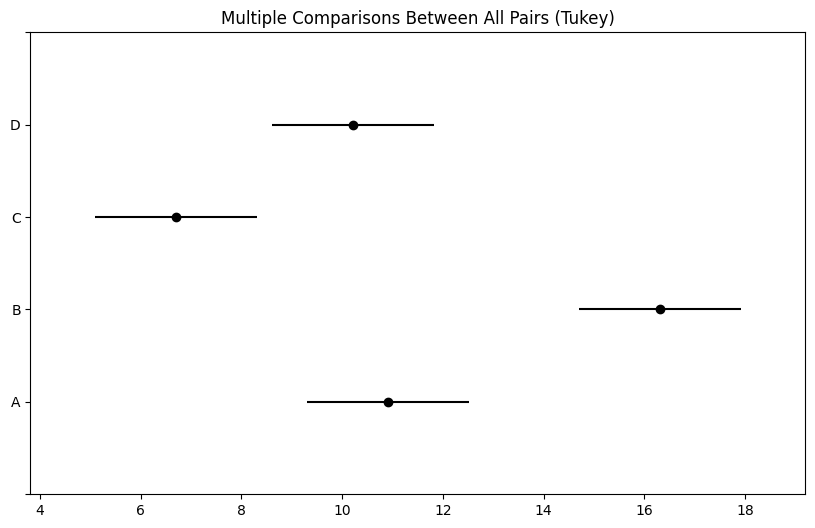

In [352]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd 
from statsmodels.stats.multicomp import MultiComparison

tukey = pairwise_tukeyhsd(df['ratio'], df['name'], alpha = 0.05)
tukey.plot_simultaneous()
plt.show()